In [19]:
import pandas as pd
import numpy as np
import math

In [ ]:
!pip uninstall fastai
!pip install https://github.com/fastai/fastai1/archive/master.zip



In [20]:
from fastai.imports import *

In [21]:
df = pd.read_csv('RELIANCE.NS.csv',parse_dates = ['Date'] )
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5353,2021-05-24,2008.000000,2009.800049,1982.000000,1985.650024,1985.650024,3946636.0
5354,2021-05-25,1996.400024,1997.000000,1960.000000,1963.150024,1963.150024,6821015.0
5355,2021-05-26,1975.000000,1979.500000,1965.300049,1970.050049,1970.050049,3452113.0
5356,2021-05-27,1970.300049,1993.000000,1962.250000,1976.099976,1976.099976,12377100.0
5357,2021-05-28,1990.000000,2105.000000,1990.000000,2094.800049,2094.800049,26060864.0


In [22]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [23]:
def add_datepart(df, fldname, drop=False):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())    
        df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [25]:
add_datepart(df,'Date')


<ipython-input-23-78961096a606>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[targ_pre+n] = getattr(fld.dt,n.lower())


In [26]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Elapsed,Month,Week,Day
0,2000-01-03,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0,2000,946857600,1,1,3
1,2000-01-04,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0,2000,946944000,1,1,4
2,2000-01-05,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0,2000,947030400,1,1,5
3,2000-01-06,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0,2000,947116800,1,1,6
4,2000-01-07,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0,2000,947203200,1,1,7


In [27]:
df = df.drop(['Date','Month','Week','Day'],axis = 1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Elapsed
0,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0,2000,946857600
1,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0,2000,946944000
2,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0,2000,947030400
3,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0,2000,947116800
4,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0,2000,947203200


,Open,High,Low,Close,Adj Close,Volume,Year,Elapsed
4271,536.910645,539.882446,531.140320,537.455444,525.379883,3275674.0,2017,1483315200
4272,539.808167,543.349609,535.474243,539.585266,527.461792,2969384.0,2017,1483401600
4273,541.318848,541.368347,527.153137,528.564758,516.688965,4796129.0,2017,1483488000
4274,530.471680,534.879883,529.357239,533.641602,521.651794,4030815.0,2017,1483574400
4275,532.056641,537.405945,531.511780,532.428101,520.465515,3620853.0,2017,1483660800


In [28]:
df = df.fillna(method = 'pad')


In [14]:
train_data.shape

(4271, 8)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
y = df['Close']
X= df.drop('Close',axis = 1)

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [33]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [34]:
clf = RandomForestRegressor(n_estimators = 300)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
metric = rmse(y_pred,y_test)
print(metric)
    
    

3.4442584570134382


In [88]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(clf, X_train); 
fi

,cols,imp
3,Adj Close,0.676610
2,Low,0.215270
1,High,0.092532
6,Elapsed,0.009930
0,Open,0.005644
4,Volume,0.000011
5,Year,0.000003


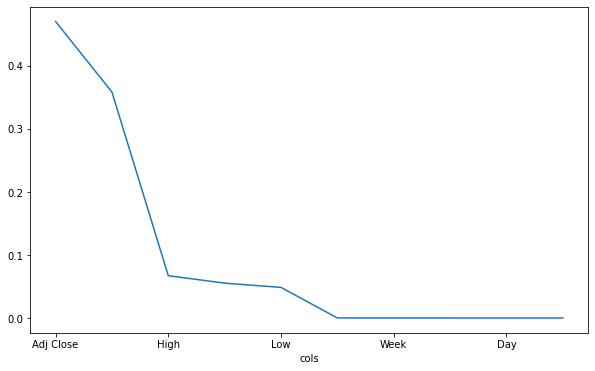

In [20]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [21]:
to_drop = fi[fi.imp < 0.01].cols
X = X.drop(to_drop,axis = 1)


In [22]:
X.head()

,Open,High,Low,Adj Close,Elapsed
0,36.747459,38.944569,36.747459,29.869350,946857600
1,39.981236,42.062302,38.882679,32.260563,946944000
2,39.710464,44.545658,39.710464,33.524399,947030400
3,44.715855,46.526150,44.715855,34.930637,947116800
4,45.644211,49.187443,45.334759,37.327774,947203200


In [23]:
clf = RandomForestRegressor(n_estimators = 300)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
metric = rmse(y_pred,y_test)
print(metric)

3.571237995754436
